In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 670.05 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os

In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [4]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [5]:
tokenizer.get_vocab_size()


544998

In [6]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [9]:
import csv

defense_ips = []
directory = "/home/toibazd/Secretion_InterPros/"
file_list = os.listdir(directory)

for file in file_list:
    print(file)
    file_path = os.path.join(directory, file)
    with open(file_path, 'r', newline='') as infile:
        reader = csv.reader(infile, delimiter = "\t")
        next(reader)
        for row in reader:
            ip = row[0]
            defense_ips.append(ip)

secretion_IP.tsv


In [10]:
print("Secretion IPs number: ", len(defense_ips))

Secretion IPs number:  164


In [11]:
from collections import defaultdict
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in defense_ips:
                data_dict[key].append(ip)


0it [00:00, ?it/s]

In [12]:
unique_defense = set()

# Iterate through each value list in the dictionary and add its elements to the set
for value_list in data_dict.values():
    unique_defense.update(value_list)

# Convert the set to a list if needed
unique_defense = list(unique_defense)

In [13]:
len(unique_defense)

156

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

4161


In [15]:
one_hot_encoded.shape

(4161, 156)

In [16]:
import os
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

directory = '/ibex/user/toibazd/InterPro/'
one_hot_encoded_sentences = {}

sentence_length = 9
sentences_per_IP = 200

# Set random seed for reproducibility
random.seed(42)

# Randomly choose 1000 files with seed 42
selected_files = os.listdir(directory)


# Define a function to process a file
def process_file(filename, IP):
    sentences = []

    filepath = os.path.join(directory, filename)

    with open(filepath, 'r') as file:
        content = file.read()
        words = content.strip().split()

        # Check if the key is in the file
        for i in range(4, len(words)-4):
            # Shuffle the indices of the words containing the key
            if IP in data_dict[words[i]]:
                if len(words) - i >= 4:
                    sentence = " ".join(words[i -4:i + sentence_length - 4])
                    sentences.append(sentence)
    return sentences


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences[IP] = []
    sentences_count = 0

    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
        for future in futures:
            sentences = future.result()
            one_hot_encoded_sentences[IP].extend(sentences)
            sentences_count += len(sentences)
            if sentences_count >= sentences_per_IP:
                break

    # Break if the required number of sentences per key is reached


 29%|██▉       | 46/156 [16:56<40:31, 22.10s/it]


KeyboardInterrupt: 

In [ ]:
import json

with open('BERT_sanity_check_secretion_DNN_senteces.json', 'w') as f:
    json.dump(one_hot_encoded_sentences, f)

In [ ]:
import json
with open('BERT_sanity_check_secretion_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)
    
    
with open('BERT_sanity_check_secretion_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)

In [18]:
for key, value in one_hot_encoded_sentences.items():
    print(key, end=" ")
    print(len(value))

IPR010263 100
IPR048130 101
IPR006533 102
IPR032389 100
IPR025955 100
IPR012842 100
IPR001639 100
IPR018920 100
IPR017847 102
IPR009371 100
IPR035576 100
IPR013391 100
IPR002010 102
IPR010586 100
IPR017737 100
IPR039366 100
IPR003895 100
IPR010130 101
IPR034026 100
IPR027282 100
IPR009211 100
IPR047659 90
IPR009863 100
IPR003283 100
IPR013369 100
IPR009929 100
IPR021545 100
IPR005714 100
IPR008312 102
IPR034756 100
IPR011850 100
IPR031758 101
IPR025292 100
IPR008514 100
IPR023835 100
IPR010290 100
IPR021368 100
IPR027628 100
IPR022250 100
IPR023834 103
IPR005696 100
IPR049928 100
IPR022792 100
IPR047695 100
IPR004683 100
IPR010128 103
IPR010129 101
IPR026264 100
IPR023787 100
IPR017739 100
IPR019861 110
IPR011841 100
IPR017740 100
IPR018893 100
IPR007606 104
IPR006304 101
IPR017738 100
IPR013363 100
IPR049875 100
IPR049801 16
IPR013365 100
IPR005838 101
IPR005415 100
IPR010132 100
IPR043993 101
IPR017750 100
IPR017735 100
IPR021055 100
IPR005628 100
IPR013388 100
IPR017033 100
IPR00781

In [19]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
print("Len of one_hot_encoded sentences items ",len(one_hot_encoded_sentences))

matching_string = one_hot_encoded_sentences.values()
print("Len of one_hot_encoded_sentences values ", len(matching_string))

matching_string = [item for sublist in matching_string for item in sublist]
print("Len of all sentences in matching strings: ", len(matching_string))

train_words_list = [sentence.split() for sentence in matching_string]

Len of one_hot_encoded sentences items  156
Len of one_hot_encoded_sentences values  156
Len of all sentences in matching strings:  15270


In [20]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
print("Len of test sentences items", len(test_sentences))
test_matching_string = test_sentences.values()
print("Len of test sentences values", len(test_matching_string))
test_matching_string = [item for sublist in test_matching_string for item in sublist]
print("Len of test sentences in matching strings: ", len(test_matching_string))


Len of test sentences items 156
Len of test sentences values 156
Len of test sentences in matching strings:  7260


In [21]:

test_words_list = [sentence.split() for sentence in test_matching_string]

fit_word_list = train_words_list+test_words_list

In [22]:
count= 0
for string in train_words_list:
    if not string[19] in data_dict.keys():
        print("False")
    else:
        count+=1
print(count)

15270


In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)
mlb.fit(fit_word_list)


one_hot_contexts = mlb.transform(train_words_list)
embeddings = one_hot_contexts.toarray()
one_hot_contexts.shape


(15270, 76641)

In [24]:
type(embeddings)

numpy.ndarray

In [25]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final_context5/"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-18 17:04:39,555] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [26]:
print(one_hot_encoded[1].shape)

(156,)


In [27]:
batch_size = 128 # Define your batch size
model.cuda()
ems = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 5, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        ems.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


  0%|          | 0/120 [00:00<?, ?it/s]

In [28]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts) 

In [29]:
pos_weights

tensor([ 76., 118., 151.,  74.,  74.,  76., 151.,  95., 151., 151., 151., 151.,
        151., 151., 150.,  83., 151.,  49., 151., 151.,  75., 123.,  74.,  49.,
        137., 109., 151., 127.,  73., 150., 151., 145., 151., 151., 150., 151.,
        148., 150., 151., 139., 151., 151., 151., 151., 151., 151., 151.,  93.,
        151., 147., 150., 150., 151., 150., 151., 151., 151., 136., 151., 125.,
        151.,  83., 151., 151., 151., 151.,  56., 147., 151., 151., 151., 151.,
        151., 151., 151., 151., 145.,  73.,  92., 151., 151., 151., 151., 151.,
        151., 117., 103., 151., 151., 151.,  92., 151., 151., 151., 131., 151.,
        151., 151., 151., 140., 151., 151.,  74., 237., 151., 151.,  75.,  75.,
        137., 151.,  75., 151., 151., 151., 148., 151., 726., 150., 151.,  75.,
        151., 147., 151., 151., 151., 151.,  82., 151., 151., 151., 245., 187.,
        237., 151., 150., 151., 150., 151.,  79., 151., 151., 151., 151., 150.,
        150., 168., 130., 151., 145., 15

In [30]:
# import random

# random.seed(42)
# # Zip the lists together
# combined = list(zip(embeddings, labels))

# # Shuffle the combined list
# random.shuffle(combined)

# # Unzip the shuffled list
# embeddings, labels = zip(*combined)



In [31]:
model.to("cpu")
torch.cuda.empty_cache()

In [32]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 76641
first_hidden = 256
second_hidden = 128
last_hidden = 64
output_dim = 156
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [33]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 256
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels


optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

clf_model.to(device)

Classification_V0(
  (fc1): Linear(in_features=76641, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=156, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [34]:
import numpy as np

num_epochs = 10
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        
        batch_embeddings = np.array(batch_embeddings)
        batch_embeddings_tensor = torch.tensor(batch_embeddings, dtype= torch.float32).cuda()
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        
        outputs = clf_model(batch_embeddings_tensor)
        loss = criterion(outputs.cpu(), batch_labels_tensor)
        train_loss+=loss.item()

        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")

Epoch 1/20:


Training Batches: 0it [00:00, ?it/s]

1.2135584843104075
Epoch 2/20:


Training Batches: 0it [00:00, ?it/s]

0.6117407558318751
Epoch 3/20:


Training Batches: 0it [00:00, ?it/s]

0.354830038773912
Epoch 4/20:


Training Batches: 0it [00:00, ?it/s]

0.2709024620430877
Epoch 5/20:


Training Batches: 0it [00:00, ?it/s]

0.23409811368391414
Epoch 6/20:


Training Batches: 0it [00:00, ?it/s]

0.2102016364037015
Epoch 7/20:


Training Batches: 0it [00:00, ?it/s]

0.19000481766036859
Epoch 8/20:


Training Batches: 0it [00:00, ?it/s]

0.1766251222401877
Epoch 9/20:


Training Batches: 0it [00:00, ?it/s]

0.1661851484477325
Epoch 10/20:


Training Batches: 0it [00:00, ?it/s]

0.15510527655121228
Epoch 11/20:


Training Batches: 0it [00:00, ?it/s]

0.14749459477132962
Epoch 12/20:


Training Batches: 0it [00:00, ?it/s]

0.1440292989184986
Epoch 13/20:


Training Batches: 0it [00:00, ?it/s]

0.14164766849999968
Epoch 14/20:


Training Batches: 0it [00:00, ?it/s]

0.13971536882421748
Epoch 15/20:


Training Batches: 0it [00:00, ?it/s]

0.13847673762133486
Epoch 16/20:


Training Batches: 0it [00:00, ?it/s]

0.1341768374689748
Epoch 17/20:


Training Batches: 0it [00:00, ?it/s]

0.13331169560600437
Epoch 18/20:


Training Batches: 0it [00:00, ?it/s]

0.13375096599026762
Epoch 19/20:


Training Batches: 0it [00:00, ?it/s]

0.13344433377908582
Epoch 20/20:


Training Batches: 0it [00:00, ?it/s]

0.12953869957664704
Training finished.


In [35]:
directory = '/ibex/user/toibazd/InterPro_testing/'
one_hot_encoded_sentences_2 = {}

sentence_length = 9
sentence_per_IP = 50
selected_files = os.listdir(directory)


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences_2[IP] = []
    sentences_count=0
    
    # Iterate over selected files
    for filename in selected_files:
        filepath = os.path.join(directory, filename)

        with open(filepath, 'r') as file:
            content = file.read()
            words = content.strip().split()

            # Check if the key is in the file
            for i in range(4, len(words)-4):
                # Shuffle the indices of the words containing the key
                if IP in data_dict[words[i]]:
                    if len(words) - i >= 4:
                        sentence = " ".join(words[i - 4:i + sentence_length - 4])
                        one_hot_encoded_sentences_2[IP].append(sentence)
                        sentences_count += 1
                        if sentences_count>=sentence_per_IP:
                            break
        if sentences_count>=sentence_per_IP:
            break
    print(sentences_count)
            


In [37]:
import json

with open('BERT_sanity_check_secretion_DNN_senteces_testing.json', 'w') as f:
    json.dump(one_hot_encoded_sentences_2, f)

In [38]:
with open('BERT_sanity_check_secretion_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)
print(len(test_sentences))

156


In [39]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
print(len(test_sentences))
test_matching_string = test_sentences.values()
len(test_matching_string)
test_matching_string = [item for sublist in test_matching_string for item in sublist]
len(test_matching_string)


156


7260

In [40]:

words_list = [sentence.split() for sentence in test_matching_string]
one_hot_contexts = mlb.transform(words_list)
embeddings = one_hot_contexts.toarray()
one_hot_contexts.shape

(7260, 76641)

In [41]:
count= 0
for string in words_list:
    if not string[19] in data_dict.keys():
        print("False")
    else:
        count+=1
print(count)

7260


In [42]:
from bertviz import model_view

batch_size = 128 # Define your batch size
# model.cuda()
test_ems = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(test_matching_string), batch_size)):
    batch_sentences = test_matching_string[i:i+batch_size]
    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions = True)
    hidden_states = outputs.last_hidden_state
    attentions = outputs.attentions[-1]
    relevant_hidden_states = hidden_states[:, 5, :]  

    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_ems.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/57 [00:00<?, ?it/s]

In [43]:
tokenizer.decode([0,12,12,12,12,
                 ])

'WP_072018053 WP_072018053 WP_072018053 WP_072018053'

In [44]:
model.to("cpu")
torch.cuda.empty_cache()

In [45]:
clf_model.eval()
clf_model.cpu()

Classification_V0(
  (fc1): Linear(in_features=76641, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=156, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [52]:
generator = data_generator(embeddings, test_labels, batch_size)
# Iterate over batches
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []
# Initialize lists to store predictions and labels across all batches
# Iterate over batches
count = 0
for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.tensor(batch_embeddings, dtype= torch.float32)
    batch_labels = np.array(batch_labels)
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.9).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [53]:
len(all_predictions[-1])

92

In [54]:
len(all_labels[-1])
    

92

In [55]:
print(all_predictions[1].shape)

(128, 156)


In [56]:
print(all_labels[-1].shape)

(92, 156)


In [57]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [58]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("AUC for each column:")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

AUC for each column:
0 :  0.9821775921482666
1 :  0.9814453529353023
2 :  0.9901151178918168
3 :  0.9452877094972066
4 :  0.9547891061452514
5 :  0.9904951117318436
6 :  0.9410221914008322
7 :  0.9950118302018094
8 :  0.9600804438280166
9 :  0.9991900138696255
10 :  0.9146074895977809
11 :  0.9966130374479889
12 :  0.9983244305583552
13 :  0.9999030470914128
14 :  1.0
15 :  0.9713637057387058
16 :  0.9977198335644938
17 :  0.9885879043600563
18 :  0.9779348127600554
19 :  0.9998058252427184
20 :  0.9620439944134079
21 :  0.9638672198071948
22 :  0.9616592178770949
23 :  0.9646174402250351
24 :  0.9629389345871358
25 :  0.954369163520763
26 :  0.9642246879334258
27 :  0.9548310185185186
28 :  0.9598924581005587
29 :  0.9897475728155339
30 :  0.9717642163661582
31 :  0.9999916782246879
32 :  0.9877031900138696
33 :  0.9791622746185852
34 :  0.9899056865464633
35 :  0.9837004160887656
36 :  0.9435936199722608
37 :  0.9360416088765603
38 :  0.9917378640776698
39 :  0.9978978423330352
40 : 

In [59]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.9884684859901474


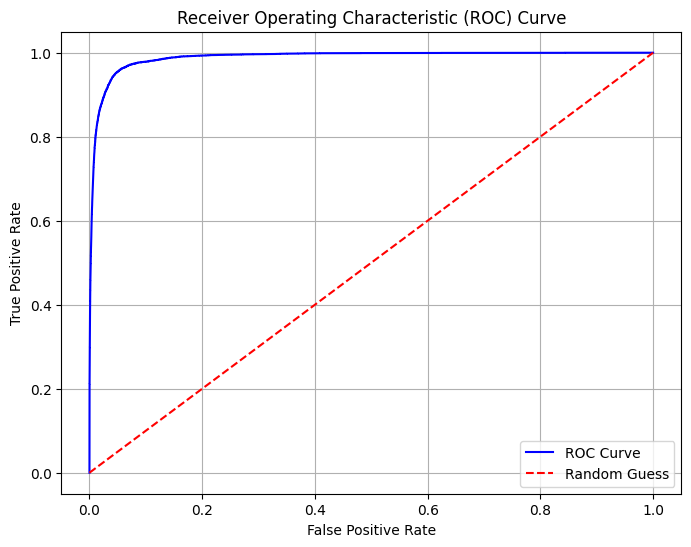

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [61]:
all_predictions.shape

(7260, 156)

In [62]:
all_labels.shape

(7260, 156)

In [63]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
156


In [64]:
print(cl_report[0])

[[6986  175]
 [  19   80]]


In [65]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [66]:
all_predictions.sum(axis=0)

array([255., 133., 143., 114., 279., 243., 181., 183.,  79.,  97.,  49.,
       125.,  44.,  47.,  50., 165.,  97., 200., 238.,  53., 256., 217.,
       287., 203., 169., 226., 225., 209.,  83., 224., 105.,  52., 193.,
       131., 228., 201., 140.,  81., 167., 118., 102., 121.,  50., 184.,
       190., 111., 284., 304., 184.,  70., 118.,  87.,  42., 149., 148.,
       108.,  30.,  76., 140., 106., 105., 249., 263., 242., 194., 188.,
       244., 128.,  51., 180., 181., 120., 224.,  26.,  47., 235., 350.,
       204., 191., 183., 369., 373., 361., 368., 400., 224.,  89., 211.,
       134.,  99., 166.,  75., 247.,  80., 109., 187., 169., 179., 105.,
       176., 214.,  48.,  83.,  13., 162.,  46., 152., 192.,  48., 111.,
       261., 166.,  53.,  68., 111.,  46.,   1.,  67., 127., 235.,  51.,
       203., 160., 102., 178., 114., 100., 119.,  31.,  62.,  25.,  18.,
        18.,  85.,  38., 109.,  70.,  25., 149.,  67.,  87.,  98.,  50.,
        69.,  15.,  27., 118.,  48.,  58.,  50.,  6

In [67]:
print(report)

              precision    recall  f1-score   support

           0       0.31      0.81      0.45        99
           1       0.32      0.75      0.45        57
           2       0.31      0.90      0.47        50
           3       0.39      0.44      0.41       100
           4       0.20      0.55      0.29       100
           5       0.38      0.92      0.54       100
           6       0.11      0.40      0.17        50
           7       0.37      0.91      0.53        75
           8       0.24      0.38      0.29        50
           9       0.52      1.00      0.68        50
          10       0.33      0.32      0.32        50
          11       0.39      0.98      0.56        50
          12       0.93      0.93      0.93        44
          13       0.85      1.00      0.92        40
          14       1.00      1.00      1.00        50
          15       0.37      0.73      0.49        84
          16       0.48      0.94      0.64        50
          17       0.60    

In [ ]:
list(enc.classes_)[36]

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
num_classes = 83
# Compute precision, recall, and thresholds for each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()

for i in range(num_classes):  # num_classes is the number of classes
    precision[i], recall[i], thresholds[i] = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
    average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
    roc_auc[i] = roc_auc_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
roc_auc["micro"] = roc_auc_score(all_labels, all_predictions, average="micro")

# Split classes into groups of 10
class_groups = [list(range(i, min(i + 10, num_classes))) for i in range(0, num_classes, 10)]

# Plot Precision-Recall and ROC curves for each group
for group in class_groups:
    plt.figure(figsize=(12, 6))

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (AUPR = {0:0.2f})'
                 ''.format(average_precision["micro"]))
    for i in group:
        plt.step(recall[i], precision[i], where='post', label='Precision-recall curve of class {0} (AUPR = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (Classes {})'.format(group))
    plt.legend(loc="best")

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr['micro'], tpr['micro'], label='Micro-average ROC curve (AUC = {0:0.2f})'
                 ''.format(roc_auc["micro"]))
    for i in group:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Classes {})'.format(group))
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [ ]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))